In [1]:
### PYCHARM ###

import fastai
import torch
from fastai.vision.all import *
from fastai.callback.fp16 import *


from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch


path = "dataset_CIFAR10"


In [2]:
### COLAB ###
"""
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
from fastbook import *
fastbook.setup_book()
from fastai.callback.fp16 import *

!unzip /content/gdrive/MyDrive/dataset_CIFAR10.zip
path = "/content/"
"""

'\n! [ -e /content ] && pip install -Uqq fastbook\nimport fastbook\nfrom fastbook import *\nfastbook.setup_book()\nfrom fastai.callback.fp16 import *\n\n!unzip /content/gdrive/MyDrive/dataset_CIFAR10.zip\npath = "/content/"\n'

In [2]:
#check if cuda is available
torch.cuda.is_available()

True

En aquest notebook mirarem de visualitzar quines són les zones activades de les imatges per saber en què s'ha basat la xarxa neuronal per prendre la seva decisió. Ens hem basat en [aquest tutorial](https://christianjmills.com/posts/fastai-book-notes/chapter-18/index.html).






In [6]:
dls = ImageDataLoaders.from_folder(
    path=path,
    train='train',
    valid='validation',
    seed=42,
    bs = 64,
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

In [83]:
learn34 = vision_learner(dls, resnet34, metrics=[accuracy, error_rate]).to_fp16()
learn34.fine_tune(6, freeze_epochs=3)


In [354]:
learn152 = load_learner(path+"/resnet152.pkl", cpu=False)

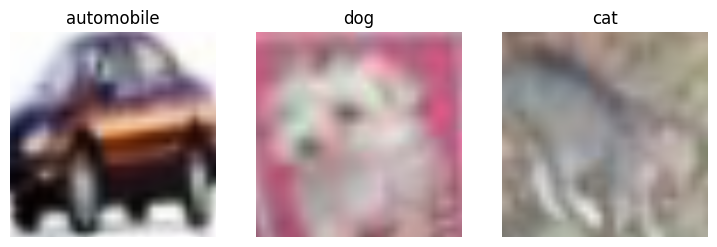

In [230]:
dls.show_batch(nrows=1, ncols=3)

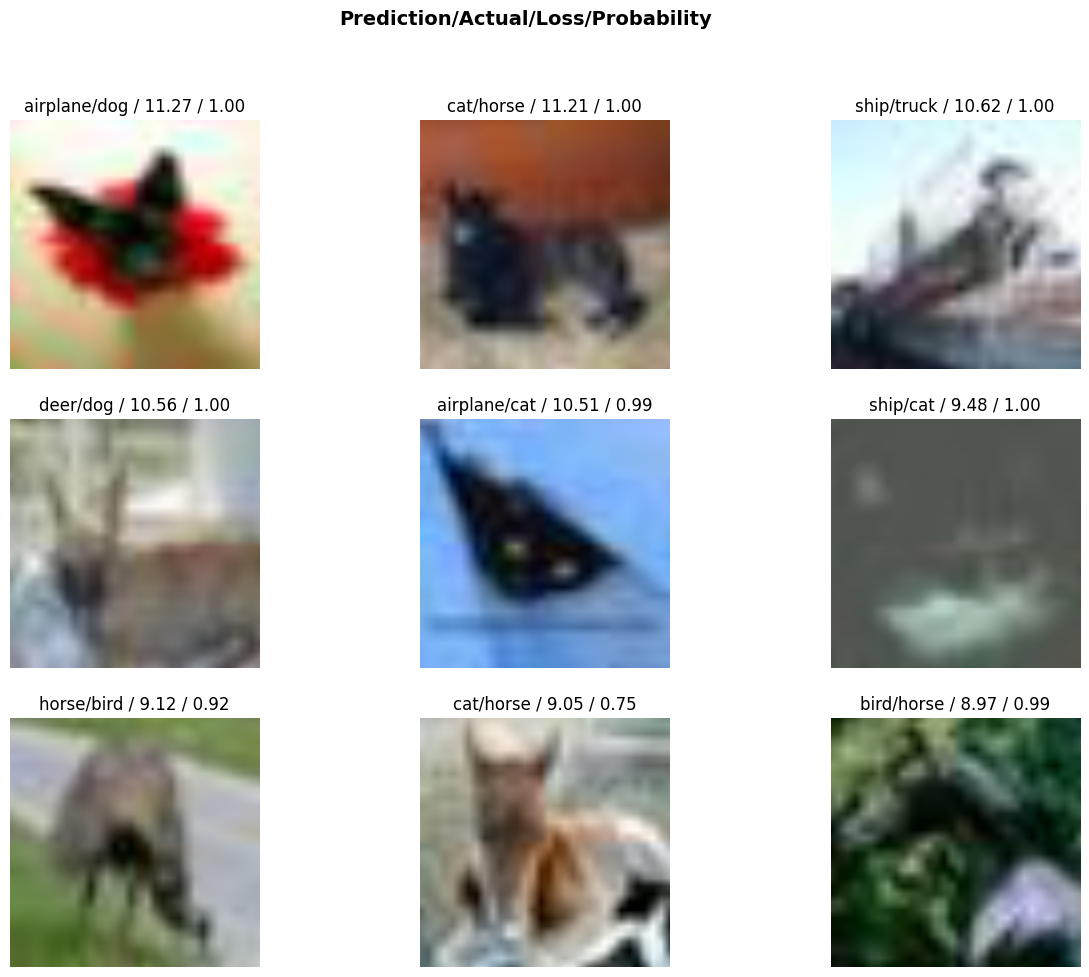

In [356]:
#plot top losses with image name
interp = ClassificationInterpretation.from_learner(learn34)
interp.plot_top_losses(9, figsize=(15,11))

### Class Activation Map (CAM)

Utilitza l'output de la última capa convolucional juntament amb les prediccions per generar un heatmap. No hem sabut adaptar-lo a resnet152, només funciona per resnet34 (la variable learn.model[1][-1].weight hauria de tenir dimensions (c,k), mentre que la variable act hauria de tenir dimensions (k,i,j), i no es compleix amb la resnet152).

In [350]:
def show_image_cam(img, learn, dls):

    # Define a hook that stores a copy of the output
    class Hook():
        def hook_func(self, m, i, o): 
            self.stored = o.detach().clone()

    # Load an image of a cat
    test_items = [img] 
    # Get a batch of data from the test set
    x, = first(dls.test_dl(test_items))

    # Instantiate a hook
    hook_output = Hook()

    # Attach the hook to the last layer in the model
    hook = learn.model[0].register_forward_hook(hook_output.hook_func)

    # Perform inference on the test batch
    with torch.no_grad(): 
        output = learn.model.eval()(x)

    # Get the copy of the model activations from the hook
    act = hook_output.stored[0]

    cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)

    # Get the first image from the test batch
    x_dec = TensorImage(dls.train.decode((x,))[0][0])

    #grid of images 
    fig, ax = plt.subplots(4, 3, figsize=(15, 15))
    
    for i in range(4):
        for j in range(3):

            x_dec.show(ctx=ax[i][j])

            if i==0 and j==0:
                ax[i][j].set_title('Original')

            else:

                index = i*3+j-1

                if index < len(dls.vocab):
                    ax[i][j].imshow(cam_map[index].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
                        interpolation='bilinear', cmap='magma');
                    ax[i][j].set_title(dls.vocab[index])

    

    # Remove the hook
    hook.remove()


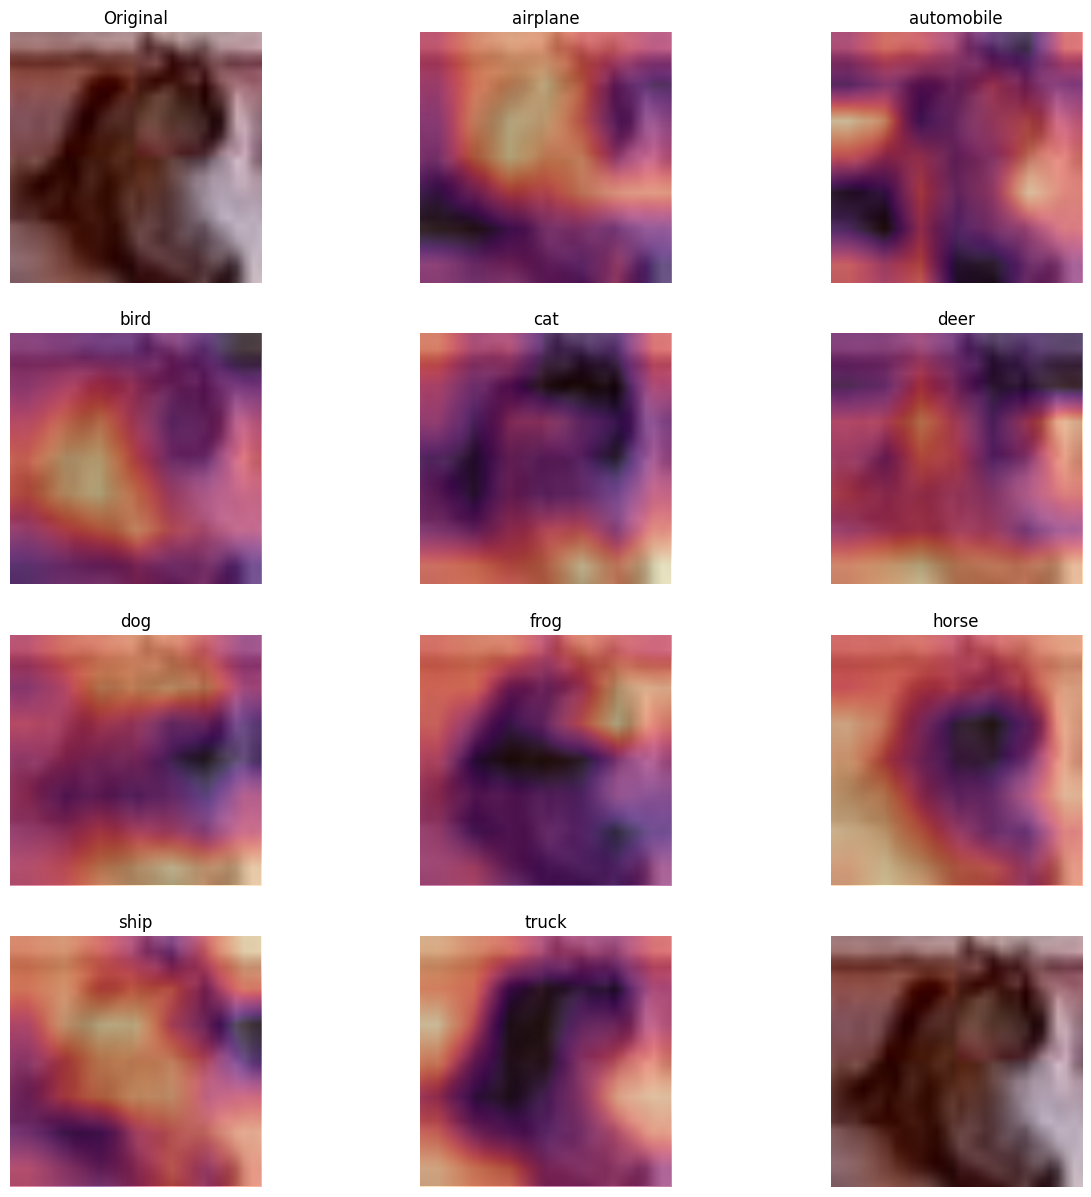

In [351]:
show_image_cam(str(path)+'/train/cat/0080.jpg', learn34, dls)

Si mostrem una imatge d'un gat, veiem com la última capa sembla fixar-se en la part inferior de la imatge (on hi ha les potes). Si mostrem un camió:

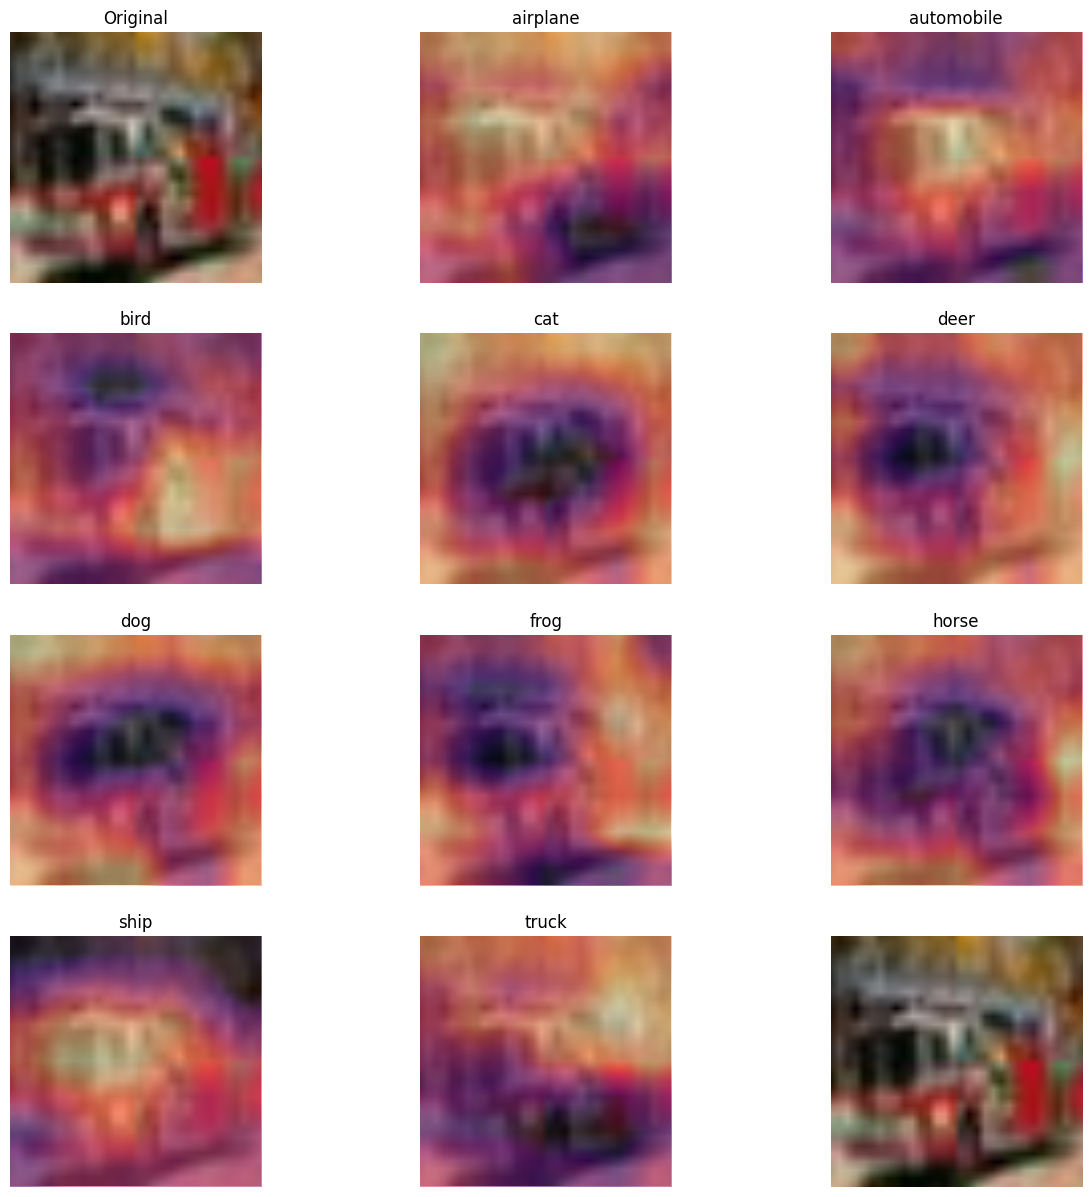

In [357]:
show_image_cam(str(path)+'/train/truck/0187.jpg', learn34, dls)

Veiem com la última capa se centra en la part superior (i sobretot la part dreta de la imatge), però no sembla que reconegui cap patró especial.

### GradCAM

In [358]:
def gradcam(img, learn, dls):


    # Load an image of a cat
    test_items = [img] 
    # Get a batch of data from the test set
    x, = first(dls.test_dl(test_items))

    # Get the first image from the test batch
    x_dec = TensorImage(dls.train.decode((x,))[0][0])



    # Update the custom hook to be a context manager
    class Hook():
        def __init__(self, m):
            self.hook = m.register_forward_hook(self.hook_func)   
        def hook_func(self, m, i, o): self.stored = o.detach().clone()
        # Automatically register the hook when entering it
        def __enter__(self, *args): return self
        # Automatically remove the hook when exiting it
        def __exit__(self, *args): self.hook.remove()
    
    # Pass the model to the `__enter__()` method for the Hook
    with Hook(learn.model[0]) as hook:
        with torch.no_grad(): output = learn.model.eval()(x.cuda())
        act = hook.stored

    # Define a hook that stores a copy of the gradients calculated by PyTorch during the backward pass
    class HookBwd():
        def __init__(self, m):
            self.hook = m.register_backward_hook(self.hook_func)   
        def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
        def __enter__(self, *args): return self
        def __exit__(self, *args): self.hook.remove()

    
    #grid of images with increased size


    fig, ax = plt.subplots(4, 3, figsize=(15, 15))

    for i in range(4):
        for j in range(3):

            #The class index
            cls = i*3+j-1

            if i == 0 and j == 0:
                x_dec.show(ctx=ax[i][j])
                ax[i][j].set_title('Original')

            elif cls < len(dls.vocab):

                with HookBwd(learn.model[0]) as hookg:
                    with Hook(learn.model[0]) as hook:
                        output = learn.model.eval()(x.cuda())
                        act = hook.stored

                    # Get the gradients for the class for the first image in the test set
                    output[0,cls].backward()
                    grad = hookg.stored

                # Calculate the average of the gradients across the feature map
                w = grad[0].mean(dim=[1,2], keepdim=True)
                cam_map = (w * act[0]).sum(0)

                x_dec.show(ctx=ax[i][j])

                
                ax[i][j].imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
                                interpolation='bilinear', cmap='magma');
                ax[i][j].set_title(dls.vocab[cls])
                


c:\Users\joans\anaconda3\envs\fastai\lib\site-packages\torch\nn\modules\module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


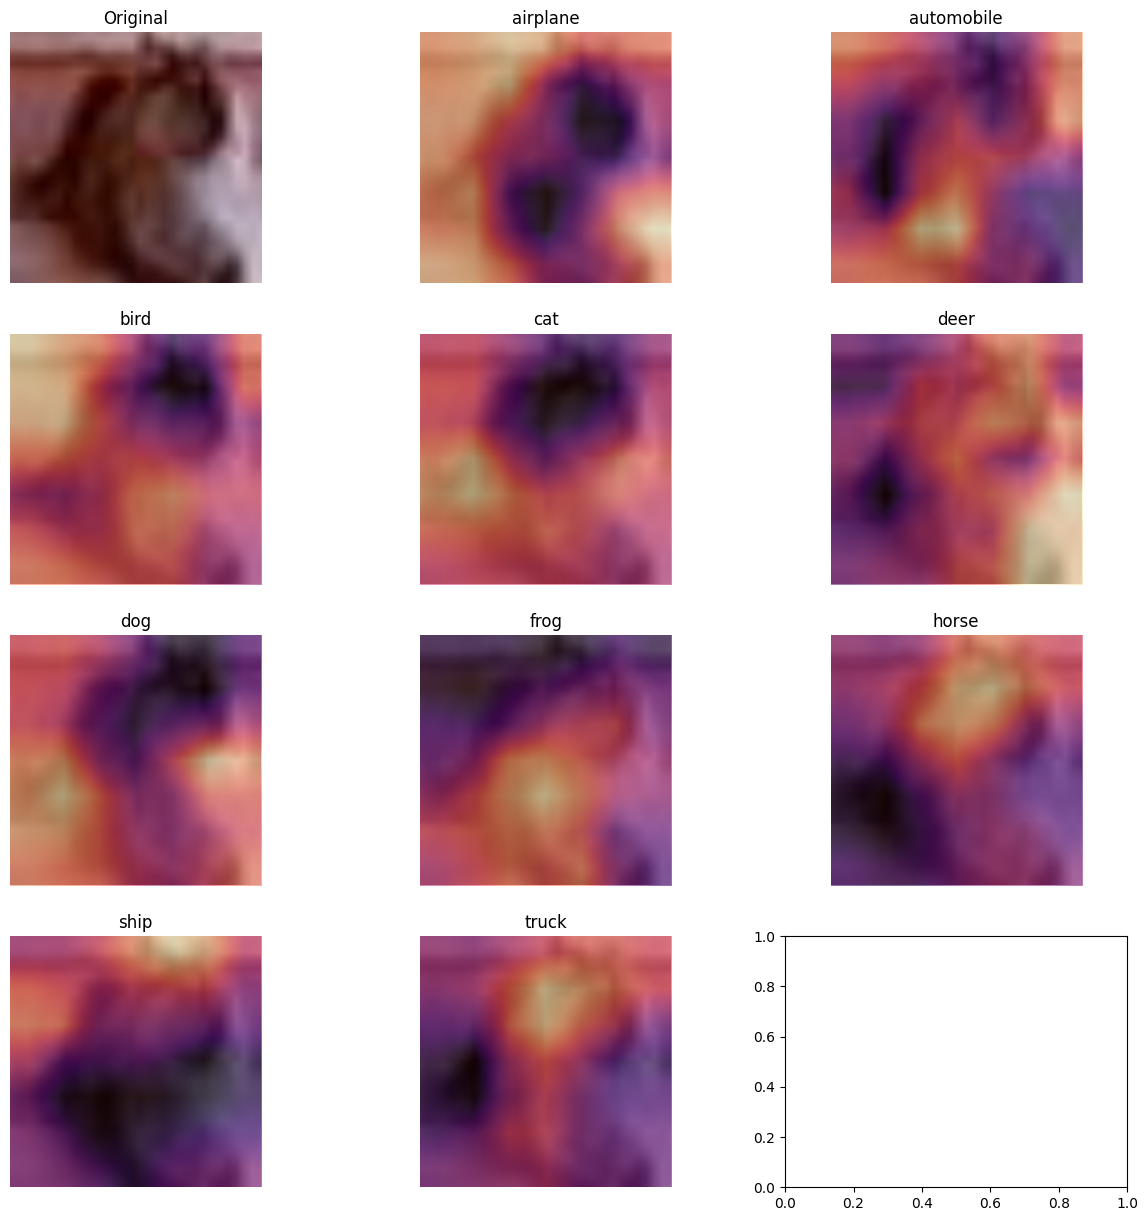

In [359]:
gradcam(str(path)+'/train/cat/0080.jpg', learn152, dls)

Si mirem la imatge del gat, veiem que GradCAM se centra en la part inferior del gat (des de la cua, les potes i una part del cap, fins al nas).

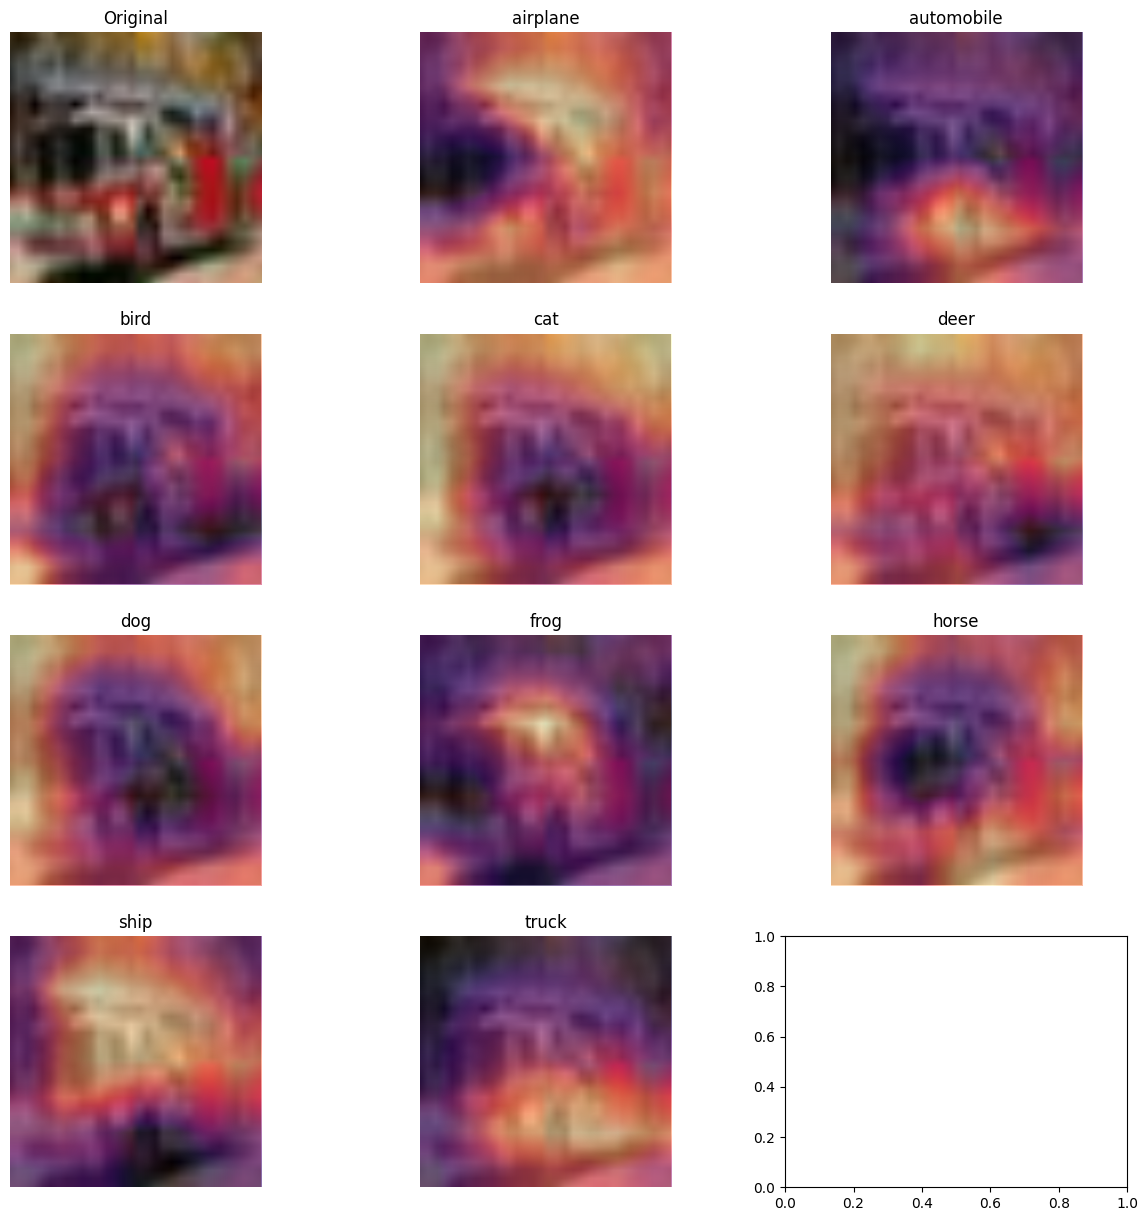

In [361]:
gradcam(str(path)+'/train/truck/0187.jpg', learn152, dls)

Si analitzem la imatge del camió, veiem com GradCAM se centra també en la part inferior del camió. 


Veiem com a diferència de la la tècnica CAM, GradCAM sí que busca els patrons en l'objecte de la imatge a classificar, mentre que CAM activa també parts de la imatge on no hi ha l'objecte en qüestió.